# Recupération des données bibliovid

In [ ]:
from google.colab import drive
import os 
drive.mount('drive')
os.chdir("drive/My Drive/Colab Notebooks/TAL/")
!ls

Mounted at drive
 biblio.csv			      nbre_par_spe.png
 bibliovid.json			      __pycache__
 biobert_v1.1_pubmed.tar.gz	      Specialite_bibliovid_2.ipynb
'Copie de Biobert_categories.ipynb'   Specialite_bibliovid.ipynb
 models				      ULMfit.ipynb


In [ ]:
# récupération des données
import json
with open('bibliovid.json') as json_data:
    data_dict = json.load(json_data)

In [ ]:
print("Nombres d'article:",len(data_dict))
print("Avec ces informations pour chacun:")
for i in data_dict:
    for cle, val in i.items():
        print(cle)
    break

Nombres d'article: 682
Avec ces informations pour chacun:
id
slug
title
has_other_authors
impact_factor
goals_plain
verbose_date
authors
document_link
specialties
category
journal
link
results
synthesis
strength_of_evidence_details
goals
methods
pubmed_id
doi
abstract
topics
author_list
publication_date


In [ ]:
print('Un exemple d\'articles:')
print(data_dict[1])

Un exemple d'articles:
{'id': 756, 'slug': 'optimal-covid-19-epidemic-control-until-vaccine-deployment', 'title': 'Optimal COVID-19 epidemic control until vaccine deployment', 'has_other_authors': True, 'impact_factor': {'id': 4, 'name': 'Indéterminé', 'posts_count': 96, 'color': 'gray', 'order': 4}, 'goals_plain': 'L\'objectif de cette étude est de déterminer des stratégies permettant le contrôle d\'une épidémie limitant au maximum le nombre de morts dûs à cette épidémie, ainsi que le coût associé à cette politique de contrôle. En particulier, l\'article prend en compte l\'augmentation de la mortalité associée à une saturation du système de santé. Différentes stratégies "réalistes" sont également considérées, comme une politique de contrôle mise à jour à intervalles réguliers, une politique de contrôle constante, ou une alternance entre période de contrôle maximal (type confinement) et minimal.', 'verbose_date': '22.07.2020', 'authors': 'Djidjou-Demasse R', 'document_link': 'https://w

In [ ]:
print('Comment sont représentés les spécialités')
print(data_dict[28]['specialties'])

Comment sont représentés les spécialités
[{'id': 21, 'name': 'Confinement/Déconfinement'}]


In [ ]:
print('Un exemple d\'abstract')
print(data_dict[0]['abstract'])

Un exemple d'abstract
Obesity is a risk factor for pneumonia and acute respiratory distress syndrome.
To determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).
Retrospective cohort study.
A quaternary academic medical center and community hospital in New York City.
2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.
Body mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.
Over a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 533 patients (22%) were intubated, 627 (25%) died, and 59 (2%) remained hospitaliz

In [ ]:
specialties = {} # dictionnaire id -> specialité
nb_per_spe = {}  # nombres d'articles par spécialité

In [ ]:
ind_spe = 0
for article in data_dict:
    for spe in article['specialties']:
        if spe['name'] not in specialties.keys():
            specialties[spe['name']] = ind_spe
            nb_per_spe[spe['name']] = 0
            ind_spe += 1
        nb_per_spe[spe['name']] += 1

In [ ]:
specialties

{'Anesthésie-Réanimation': 0,
 'Cardiologie et maladies métaboliques': 10,
 'Confinement/Déconfinement': 5,
 'Dermatologie': 15,
 'Gynécologie Obstétrique': 8,
 'Gériatrie': 9,
 'Hygiène': 11,
 'Hématologie': 16,
 'Hépato-gastro-entérologie': 12,
 'Immunité': 3,
 'Infectiologie': 1,
 'Neurologie': 13,
 'Néphrologie': 18,
 'Pneumologie': 7,
 'Psychiatrie': 17,
 'Pédiatrie': 6,
 'Radiologie': 14,
 'Transversale': 2,
 'Virologie': 4}

In [ ]:
LABELS = list(specialties.keys())

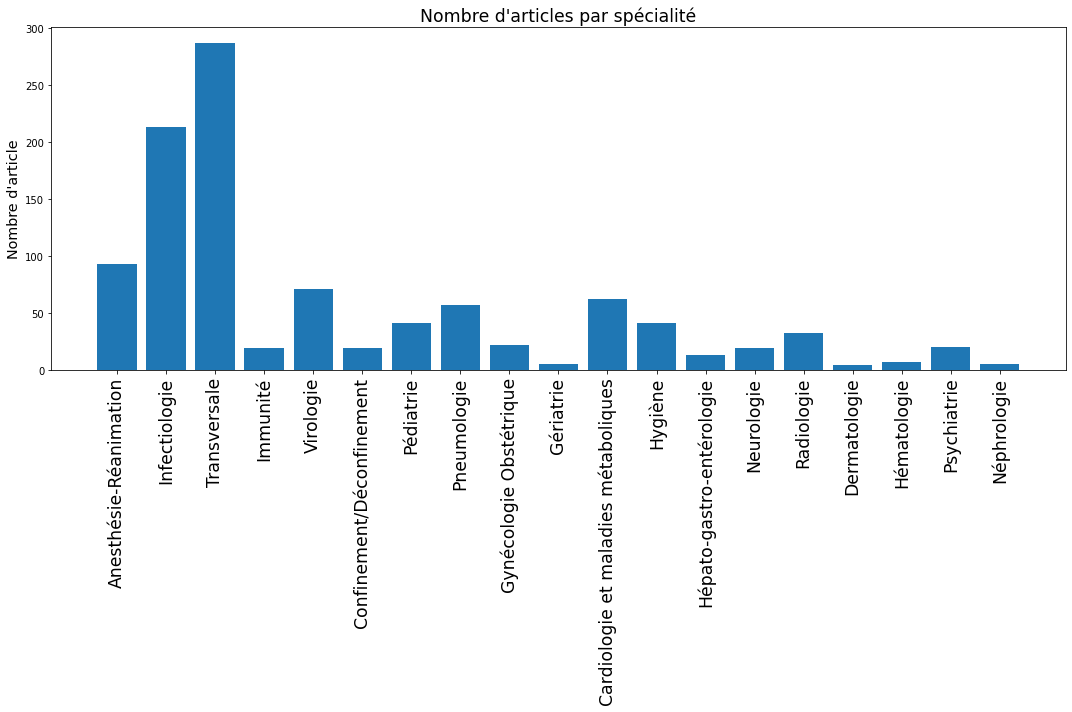

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(15,10))
plt.bar(np.arange(19), nb_per_spe.values())
plt.title('Nombre d\'articles par spécialité',size='xx-large')
plt.ylabel('Nombre d\'article',size='x-large')
plt.xticks(np.arange(19), nb_per_spe.keys(), rotation='vertical',size='xx-large')
plt.tight_layout()
fig.savefig('nbre_par_spe.png')
plt.show()

On remarque que certaines spécialités sont très peu représentés (Dermatologie, Gériatrie, Néphrologie), ce qui risque de poser problèmes pour des modèles entrainés depuis 0.

Au contraire, nous avons beaucoup d'exemples pour la spécialité "Transversale", et ce n'est sûrement pas très pertinent car cette spécialité va finalement en englober plusieurs et cela risque de "brouiller" nos classifieurs. On pourrait par exemple mettre la spécialité Transversale si on a déjà prédit 2 spécialité pour l'article.

## Préparation des données

On va récupérer les données qui nous intéresse.

In [ ]:
import utils
texts, Y = utils.get_data(data_dict, get_abstract = False)

In [ ]:
print("y shape:",Y.shape)

y shape: (682, 19)


Sur les 682 articles que l'on a, on en a 207 qui n'ont pas d'abstract. On va tenter dans un premier temps de prédire la classe seulement avec le titre afin que toutes les données fassent à peu près la même longueur.

Nous allons utiliser les représentations CountVectorizer et TfidVectorizer.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer(stop_words="english", max_features=2000, min_df=1)  #max_df
vect.fit(texts)
vect2 = TfidfVectorizer(stop_words="english", max_features=2000, min_df=1)  #max_df
vect2.fit(texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=2000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
print("TfidVectorizer")
print("Vocabulary size: {}".format(len(vect2.vocabulary_)))
print("Vocabulary content:\n {}".format(vect2.vocabulary_))

TfidVectorizer
Vocabulary size: 1792
Vocabulary content:
 {'body': 220, 'mass': 978, 'index': 809, 'risk': 1411, 'intubation': 868, 'death': 420, 'sars': 1429, 'cov': 391, 'infection': 821, 'retrospective': 1399, 'cohort': 307, 'study': 1566, 'optimal': 1120, 'covid': 393, '19': 21, 'epidemic': 559, 'control': 359, 'vaccine': 1725, 'deployment': 439, 'contact': 348, 'rate': 1319, 'equilibrium': 565, 'view': 1750, 'hydroxychloroquine': 744, 'treatment': 1673, 'prophylaxis': 1278, 'non': 1092, 'human': 739, 'primates': 1254, 'infectivity': 824, 'profile': 1266, 'correction': 378, 'mrna': 1039, 'preliminary': 1241, 'report': 1376, 'pathophysiology': 1155, 'transmission': 1665, 'diagnosis': 463, 'coronavirus': 376, 'disease': 483, '2019': 25, 'review': 1404, 'introductions': 866, 'early': 520, 'spread': 1529, 'france': 671, '24': 32, 'january': 888, '23': 31, 'march': 972, '2020': 27, 'opensafely': 1118, 'factors': 623, 'associated': 178, '17': 20, 'million': 1014, 'patients': 1157, 'model

In [ ]:
bag_of_words = vect.transform(texts)
bag_of_words2 = vect2.transform(texts)


### Séparation test / train

Nous allons séparer les données en données d'entrainement et de test. Nous utiliserons que la représentation Tfid car avec la représentation CountVectorizer, ce n'est pas bon du tout (voir dans rapport).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bag_of_words2, Y, test_size=0.2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(bag_of_words, Y, test_size=0.2)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(545, 1792) (545, 19)
(137, 1792) (137, 19)


## KNN
On va d'abord tester avec les modèles sk-learn qui nous permettent de traiter les problèmes multi-label. Ci-dessous les modèles sont entrainés seulement avec les titres des articles avec une représentation TFid. Nous avons tester aussi avec les abstract et/ ou la représentation CountVectorizer mais c'était moins bon (voir résultats dans rapport).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
k_range = list(range(1,15))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 3, scoring = 'f1_micro')
grid.fit(X_train,y_train)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.4530529128535257
{'n_neighbors': 4, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')


In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
score = f1_score(y_test,y_pred , average='micro',zero_division=0)
score

0.47230320699708456

In [ ]:
KNN = {'f1-micro':score, 'f1-macro':f1_score(y_test,y_pred , average='macro',zero_division=0),'f1-weighted': f1_score(y_test,y_pred , average='weighted',zero_division=0),'f1-samples':f1_score(y_test,y_pred , average='samples',zero_division=0)}
KNN

{'f1-macro': 0.3651784324114907,
 'f1-micro': 0.47230320699708456,
 'f1-samples': 0.4233576642335766,
 'f1-weighted': 0.460829595665916}

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = forest.predict(X_test)
score = f1_score(y_test,y_pred , average='samples',zero_division=0)

In [ ]:
RandomForest= {'f1-micro':score, 'f1-macro':f1_score(y_test,y_pred , average='macro',zero_division=0),'f1-weighted': f1_score(y_test,y_pred , average='weighted',zero_division=0),'f1-samples':f1_score(y_test,y_pred , average='samples',zero_division=0)}
RandomForest

{'f1-macro': 0.17046623714922368,
 'f1-micro': 0.4153284671532846,
 'f1-samples': 0.4153284671532846,
 'f1-weighted': 0.34355182231069625}

In [ ]:
scores_tfid = pd.DataFrame(index=['KNN', 'Random Forest'], columns=['f1-micro', 'f1-macro','f1-weighted','f1-samples'])
scores_tfid.loc['KNN'] = pd.Series(KNN)
scores_tfid.loc['Random Forest'] = pd.Series(RandomForest)
scores_tfid

,f1-micro,f1-macro,f1-weighted,f1-samples
KNN,0.472303,0.365178,0.46083,0.423358
Random Forest,0.415328,0.170466,0.343552,0.415328


## Prédictions des classes une par une : stratégie one vs rest

On fait une régréssion logistique binaire pour tous les labels pour prédire si oui ou non on aura ce label pour ce texte. (inspiré de https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

On suppose donc ici qu'il n'y a pas de corrélation entre les labels.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
            ])

In [ ]:
for label in range(len(LABELS)):
    print('**Label {} **'.format(LABELS[label]))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train[:,label])
    print("Entrainé avec ",np.shape(np.where(y_train[:,label]==1))[1],"exemples avec ce label")
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Accuracy: {}'.format(accuracy_score(y_test[:,label], prediction)))
    print("Testé sur ",np.shape(np.where(y_test[:,label]==1))[1],"exemples")
    print("\n")

**Label Anesthésie-Réanimation **
Entrainé avec  72 exemples avec ce label
Accuracy: 0.8467153284671532
Testé sur  21 exemples


**Label Infectiologie **
Entrainé avec  159 exemples avec ce label
Accuracy: 0.6204379562043796
Testé sur  54 exemples


**Label Transversale **
Entrainé avec  239 exemples avec ce label
Accuracy: 0.6715328467153284
Testé sur  48 exemples


**Label Immunité **
Entrainé avec  15 exemples avec ce label
Accuracy: 0.9708029197080292
Testé sur  4 exemples


**Label Virologie **
Entrainé avec  48 exemples avec ce label
Accuracy: 0.8321167883211679
Testé sur  23 exemples


**Label Confinement/Déconfinement **
Entrainé avec  15 exemples avec ce label
Accuracy: 0.9708029197080292
Testé sur  4 exemples


**Label Pédiatrie **
Entrainé avec  28 exemples avec ce label
Accuracy: 0.9051094890510949
Testé sur  13 exemples


**Label Pneumologie **
Entrainé avec  44 exemples avec ce label
Accuracy: 0.9051094890510949
Testé sur  13 exemples


**Label Gynécologie Obstétrique **


Nous obtenons donc 19 classifieurs (1 pour chaque spécialité) expert sur sa spécialité, mais finalement ça ne parait pas pertinent car il y a des spécialités où il y a trop peu de données, le classifieur ne peut pas apprendre grand chose de cette manière. Nous n'irons donc pas plus loin pour cette approche.

## Conclusion

Les classifieurs "classiques" multilabels ne nous permettent pas d'avoir de bons résultats au vu du manque de certaines données. Nous allons maintenant tester et nous concentrer sur des méthodes deep, comme par exemple le modèle BioBert déjà pré-entrainé sur des données médicales qui permet (il parait), de bons résultats même avec très peu de données.